Basically this is a very simple LSTM model using Keras. Inspired by this project on Github: https://github.com/miguelgfierro/sciblog_support/blob/master/Time_Series_Forecasting_of_Stock_Price/Stock_Price_Forecasting.ipynb

Architeture: 

One LSTM layer with 64 nodes, drop rate is 0.2, and time step is 10;
             
Some of the hyperparameters are using parameters in this article: 
https://lilianweng.github.io/lil-log/2017/07/08/predict-stock-prices-using-RNN-part-1.html
             
Train test split: Using first 70% of data as train and the rest 30% as test;

Inputs: besides the four variables, I also calculated mid-price, bid-ask-spread, volume diff., and some derivatives of price and volume. Some of the features are based on this paper: 

"Modeling high-frequency limit order book dynamics with support vector machines"
https://raw.github.com/ezhulenev/scala-openbook/master/assets/Modeling-high-frequency-limit-order-book-dynamics-with-support-vector-machines.pdf
             
Comments: I also tried two layers of LSTM with nodes 64 and 16. But the result is worse.




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, LSTM
import tensorflow as tf
import keras.backend as K

D:\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
timestep_size = 10

batch_size = 5000

In [3]:
data_path = r'E:\My Documents\NYU\Courses\FRE 9733 Machine Learning\Project' 
data = pd.read_csv(data_path+'\data_project.csv', delimiter=r"\s+", index_col = ['timestamp'])
data.index = pd.to_datetime(data.index/1000000,unit='s')
data = data.groupby(data.index).first()

data['mid'] = (data['bid'] + data['ask'])/2
data['spread'] = data['bid'] - data['ask']
data['vol_diff']=data['bidsize'] - data['asksize']
data['dt']=data.index.to_series().diff(1).apply(pd.Timedelta.total_seconds)
data['d_ask'] = (data['ask'].diff(1)/data['dt']/10000).apply(np.tanh)
data['d_bid'] = (data['bid'].diff(1)/data['dt']/10000).apply(np.tanh)
data['d_asksize'] = (data['asksize'].diff(1)/data['dt']/1000000).apply(np.tanh)
data['d_bidsize'] = (data['bidsize'].diff(1)/data['dt']/1000000).apply(np.tanh)

prediction_data = pd.read_csv(data_path+'\prediction_data.csv', index_col = ['timestamp'])
prediction_data.index = pd.to_datetime(prediction_data.index)

raw_x = data.dropna()
input_size = len(raw_x.columns)
dims = input_size * timestep_size

y = prediction_data.loc[raw_x.index.unique()]
y = y.groupby(y.index).first()

scaler = StandardScaler()

def to_1dimension(df, input_size, step_size):
    X = []
    for i in range(len(df)-step_size+1):
        data = df[i:(i+step_size),:].reshape([1,dims])
        X.append(data)
    X = np.array(X)
    X = np.reshape(X, (X.shape[0], step_size, input_size))
    return X

success_result = []
return_result = []

In [4]:
def lstm_model(raw_y, epochs=50, drop_rate=0.2, lstm_size1=32, lstm_size2=16):    
    X_train, X_test, y_train, y_test = train_test_split(raw_x, raw_y, test_size=0.3, shuffle=False)
    
    price_now_orign = X_test.iloc[:,4].values.reshape(-1)
    
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)
    y_train = scaler.fit_transform(y_train).reshape(-1)
    y_test = scaler.fit_transform(y_test).reshape(-1)
    
    price_now = X_test[:,4].reshape(-1)

    X_train = to_1dimension(X_train, input_size, timestep_size)
    X_test = to_1dimension(X_test, input_size, timestep_size)

    y_train = y_train[timestep_size-1:]
    y_test = y_test[timestep_size-1:]
    price_now = price_now[timestep_size-1:]
    price_now_orign = price_now_orign[timestep_size-1:]
    
    model = Sequential()

    model.add(LSTM(lstm_size1, input_shape=(timestep_size, input_size)))
    model.add(Dropout(drop_rate))
    
    #model.add(LSTM(lstm_size1, return_sequences=True, input_shape=(timestep_size, input_size)))
    #model.add(Dropout(drop_rate))
    #model.add(LSTM(lstm_size2))
    #model.add(Dropout(drop_rate))
    
    model.add(Dense(1, activation='linear'))

    model.compile(optimizer='adam', loss = 'mean_squared_error')
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)
    
    y_test_inv = scaler.inverse_transform([y_test]).reshape(-1)
    y_pred = model.predict(X_test).reshape(-1)
    #y_pred = scaler.inverse_transform(y_pred).reshape(-1)
    #score = math.sqrt(mean_squared_error(y_test_inv, y_pred))
    score = math.sqrt(mean_squared_error(y_test, y_pred))
    print('Test RMSE: %.2f' % (score)) 
    
    plt.figure(figsize=(12,9))
    plt.plot(y_test)
    plt.plot(y_pred)
    plt.legend(['y_true','y_pred'])
    plt.show()
    
    

    condition1 = (price_now < y_pred)
    #condition2 = (y_pred < y_test_inv)
    condition2 = (y_pred < y_test)
    success = (condition1 == condition2)

    print('success rate:', success.sum()/len(success))
    
    #condition3 = (price_now < y_test_inv)
    condition3 = (price_now < y_test)
    success2 = (condition1 == condition3)

    print('success rate for predict up or down:', success2.sum()/len(success2))
    
    
    
    ret = np.array((y_test_inv - price_now_orign)/price_now_orign)
    long_or_short = 2*condition1 - 1

    ret = ret * long_or_short
    ret_cum = np.cumprod((ret+1)) - 1
    plt.figure(figsize=(12,9))
    plt.plot(ret_cum*100)
    plt.title('total return after prediction')
    plt.xlabel('prediction times')
    plt.ylabel('return rate %')
    plt.show()
    
    success_result.append(success.sum()/len(success))
    return_result.append(ret_cum)

Epoch 1/50
14437/14437 [==============================] - 2s 164us/step - loss: 0.8127
Epoch 2/50
14437/14437 [==============================] - 1s 98us/step - loss: 0.5017
Epoch 3/50
14437/14437 [==============================] - 1s 101us/step - loss: 0.2700
Epoch 4/50
14437/14437 [==============================] - 1s 100us/step - loss: 0.1216
Epoch 5/50
14437/14437 [==============================] - 1s 98us/step - loss: 0.0608
Epoch 6/50
14437/14437 [==============================] - 1s 97us/step - loss: 0.0654
Epoch 7/50
14437/14437 [==============================] - 1s 101us/step - loss: 0.0772
Epoch 8/50
14437/14437 [==============================] - 1s 99us/step - loss: 0.0650
Epoch 9/50
14437/14437 [==============================] - 1s 100us/step - loss: 0.0457
Epoch 10/50
14437/14437 [==============================] - 2s 106us/step - loss: 0.0331
Epoch 11/50
14437/14437 [==============================] - 1s 103us/step - loss: 0.0314
Epoch 12/50
14437/14437 [====================

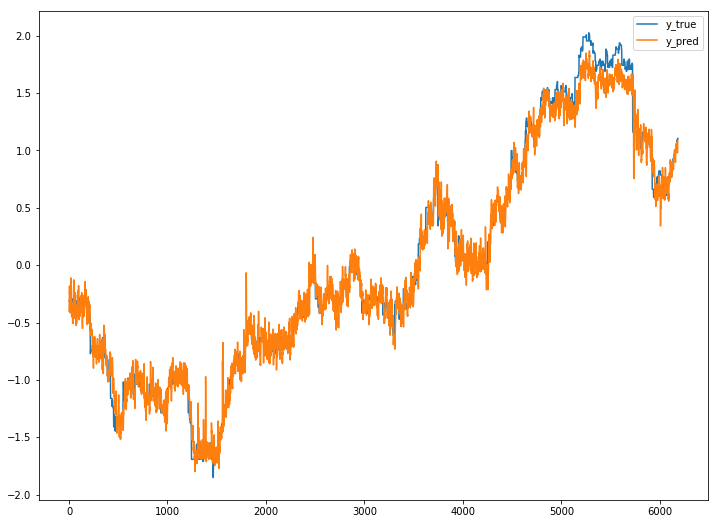

success rate: 0.15041242115477924
success rate for predict up or down: 0.49442018437651625


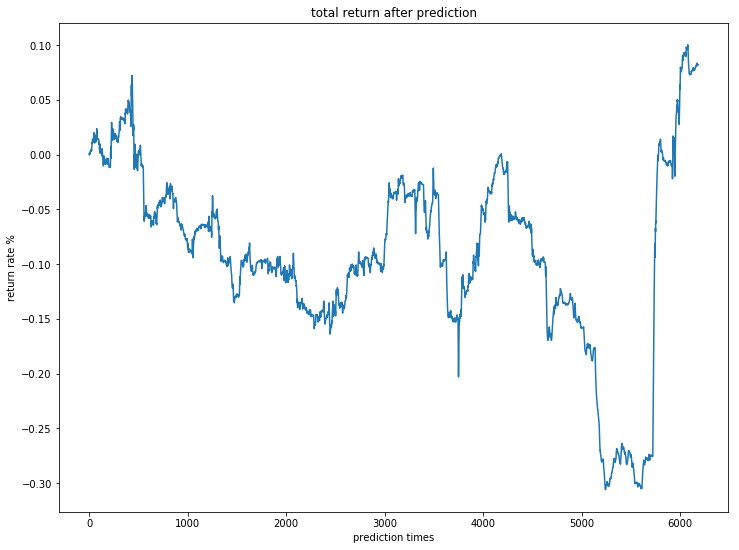

In [5]:
lstm_model(y[['mid in 0.1s']], epochs=50, drop_rate=0.2, lstm_size1=64)

Epoch 1/50
14437/14437 [==============================] - 3s 183us/step - loss: 0.4771
Epoch 2/50
14437/14437 [==============================] - 1s 98us/step - loss: 0.2637
Epoch 3/50
14437/14437 [==============================] - 1s 102us/step - loss: 0.1096
Epoch 4/50
14437/14437 [==============================] - 1s 97us/step - loss: 0.0403
Epoch 5/50
14437/14437 [==============================] - 1s 102us/step - loss: 0.0362
Epoch 6/50
14437/14437 [==============================] - 1s 100us/step - loss: 0.0571
Epoch 7/50
14437/14437 [==============================] - 1s 98us/step - loss: 0.0568
Epoch 8/50
14437/14437 [==============================] - 1s 100us/step - loss: 0.0410
Epoch 9/50
14437/14437 [==============================] - 2s 106us/step - loss: 0.0270
Epoch 10/50
14437/14437 [==============================] - 1s 104us/step - loss: 0.0235
Epoch 11/50
14437/14437 [==============================] - 1s 97us/step - loss: 0.0259
Epoch 12/50
14437/14437 [====================

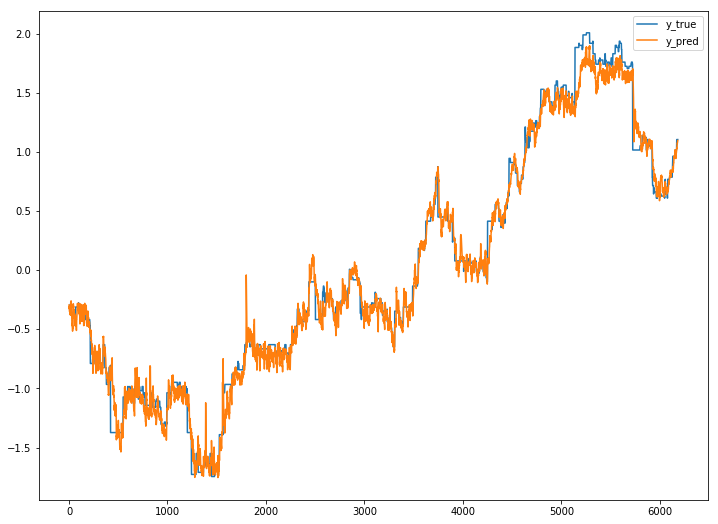

success rate: 0.24907003072941938
success rate for predict up or down: 0.5342066957787481


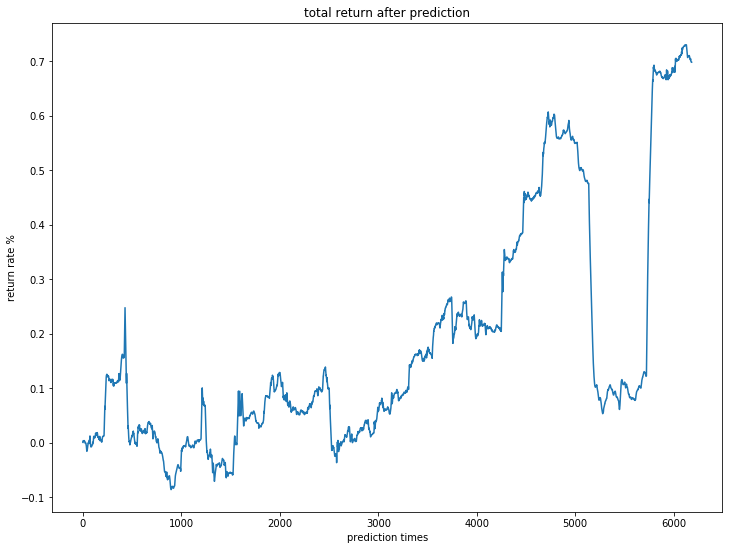

In [6]:
lstm_model(y[['mid in 0.5s']], epochs=50, drop_rate=0.2, lstm_size1=64)

Epoch 1/50
14437/14437 [==============================] - 3s 173us/step - loss: 0.7145
Epoch 2/50
14437/14437 [==============================] - 1s 102us/step - loss: 0.4045
Epoch 3/50
14437/14437 [==============================] - 1s 101us/step - loss: 0.1895
Epoch 4/50
14437/14437 [==============================] - 2s 104us/step - loss: 0.0736
Epoch 5/50
14437/14437 [==============================] - 1s 100us/step - loss: 0.0515
Epoch 6/50
14437/14437 [==============================] - 1s 103us/step - loss: 0.0786
Epoch 7/50
14437/14437 [==============================] - 1s 99us/step - loss: 0.0839
Epoch 8/50
14437/14437 [==============================] - 1s 98us/step - loss: 0.0644
Epoch 9/50
14437/14437 [==============================] - 1s 99us/step - loss: 0.0449
Epoch 10/50
14437/14437 [==============================] - 1s 100us/step - loss: 0.0369
Epoch 11/50
14437/14437 [==============================] - 1s 99us/step - loss: 0.0382
Epoch 12/50
14437/14437 [====================

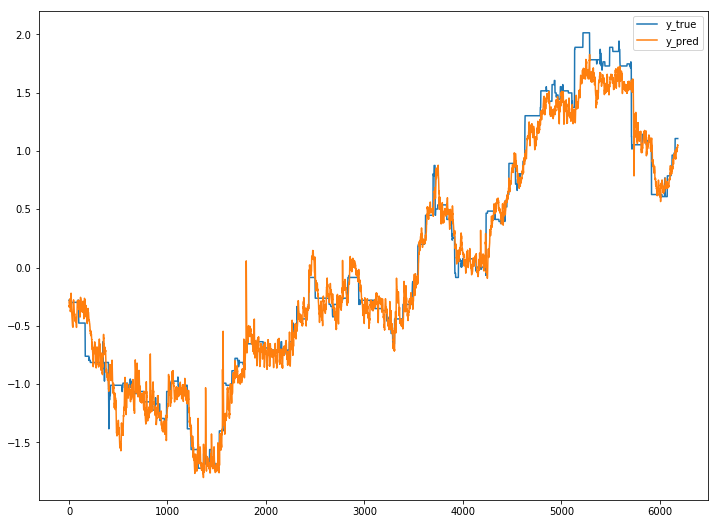

success rate: 0.2683163512857836
success rate for predict up or down: 0.5214297266699014


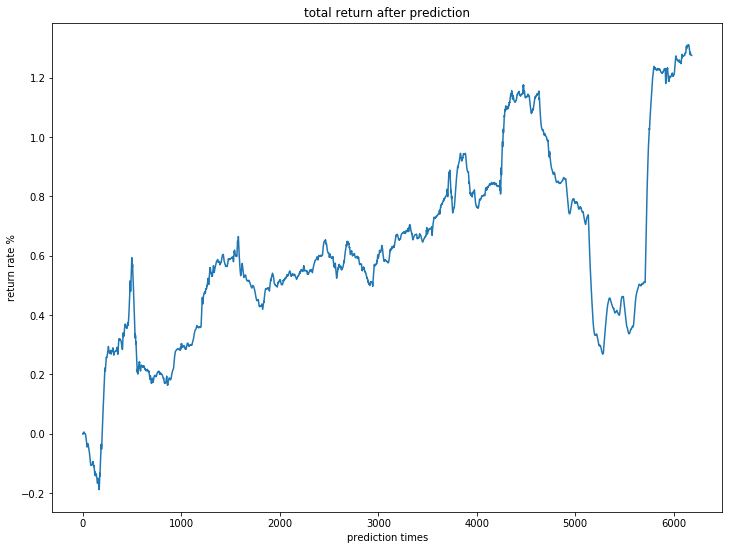

In [7]:
lstm_model(y[['mid in 5s']], epochs=50, drop_rate=0.2, lstm_size1=64)

Epoch 1/50
14437/14437 [==============================] - 3s 185us/step - loss: 0.5493
Epoch 2/50
14437/14437 [==============================] - 1s 102us/step - loss: 0.3108
Epoch 3/50
14437/14437 [==============================] - 1s 98us/step - loss: 0.1413
Epoch 4/50
14437/14437 [==============================] - 1s 97us/step - loss: 0.0630
Epoch 5/50
14437/14437 [==============================] - 1s 98us/step - loss: 0.0647
Epoch 6/50
14437/14437 [==============================] - 1s 98us/step - loss: 0.0867
Epoch 7/50
14437/14437 [==============================] - 1s 99us/step - loss: 0.0832
Epoch 8/50
14437/14437 [==============================] - 1s 97us/step - loss: 0.0625
Epoch 9/50
14437/14437 [==============================] - 1s 97us/step - loss: 0.0487
Epoch 10/50
14437/14437 [==============================] - 1s 100us/step - loss: 0.0462
Epoch 11/50
14437/14437 [==============================] - 1s 97us/step - loss: 0.0485
Epoch 12/50
14437/14437 [========================

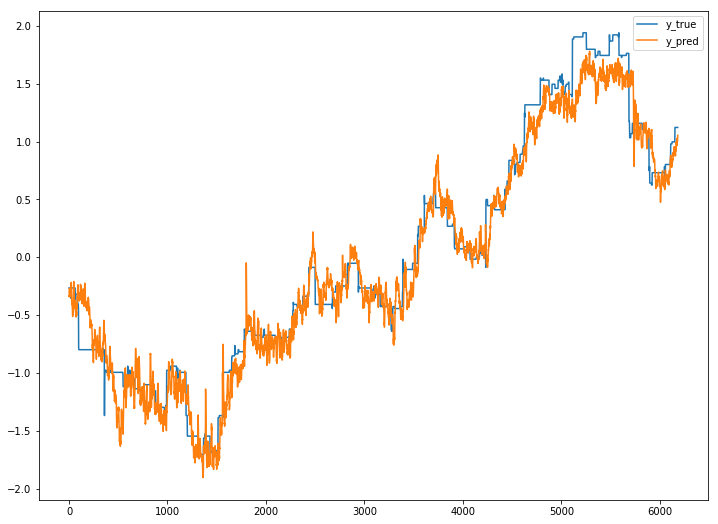

success rate: 0.26944848778909913
success rate for predict up or down: 0.5170629144428271


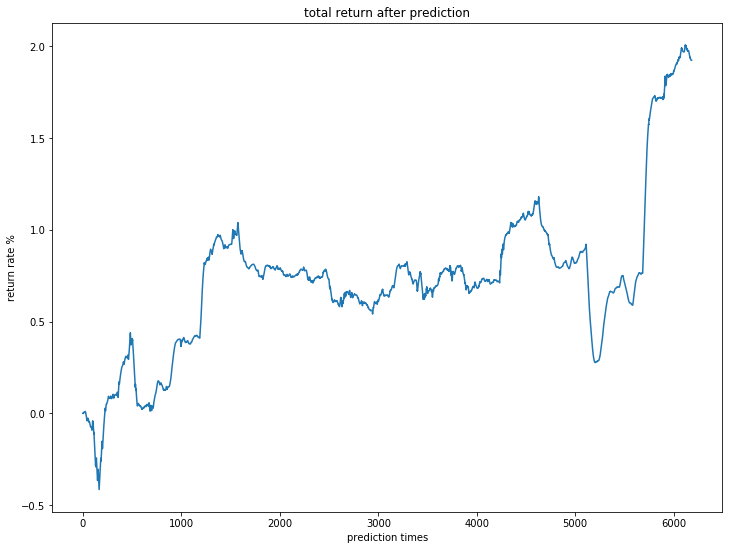

In [8]:
lstm_model(y[['mid in 10s']], epochs=50, drop_rate=0.2, lstm_size1=64)

Epoch 1/50
14437/14437 [==============================] - 3s 201us/step - loss: 0.7950
Epoch 2/50
14437/14437 [==============================] - 2s 107us/step - loss: 0.4728
Epoch 3/50
14437/14437 [==============================] - 1s 97us/step - loss: 0.2429
Epoch 4/50
14437/14437 [==============================] - 2s 106us/step - loss: 0.1090
Epoch 5/50
14437/14437 [==============================] - 2s 108us/step - loss: 0.0763
Epoch 6/50
14437/14437 [==============================] - 2s 108us/step - loss: 0.1025
Epoch 7/50
14437/14437 [==============================] - 2s 109us/step - loss: 0.1168
Epoch 8/50
14437/14437 [==============================] - 2s 105us/step - loss: 0.1023
Epoch 9/50
14437/14437 [==============================] - 1s 101us/step - loss: 0.0771
Epoch 10/50
14437/14437 [==============================] - 1s 100us/step - loss: 0.0669
Epoch 11/50
14437/14437 [==============================] - 1s 97us/step - loss: 0.0677
Epoch 12/50
14437/14437 [==================

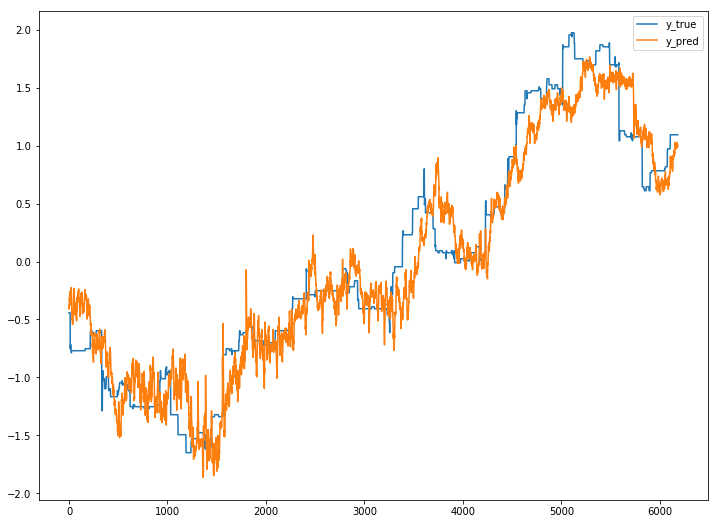

success rate: 0.3888080219957949
success rate for predict up or down: 0.5236939996765324


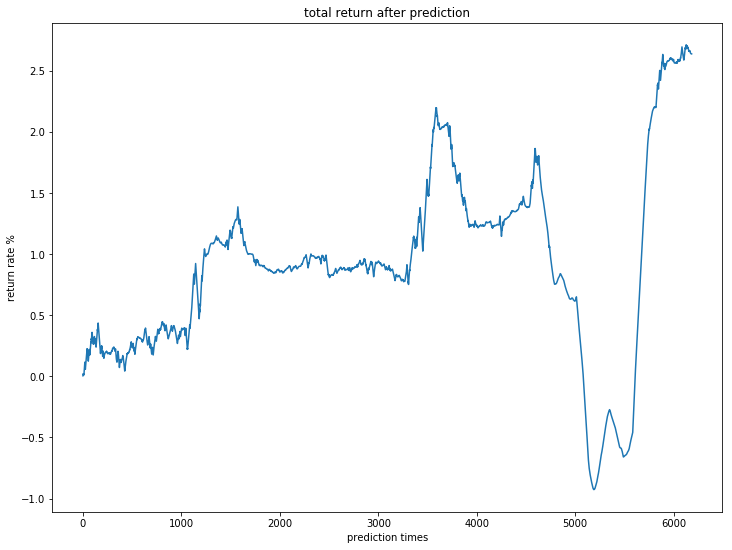

In [9]:
lstm_model(y[['mid in 30s']], epochs=50, drop_rate=0.2, lstm_size1=64)

In [15]:
success_result

[0.15041242115477924,
 0.24907003072941938,
 0.2683163512857836,
 0.26944848778909913,
 0.3888080219957949]

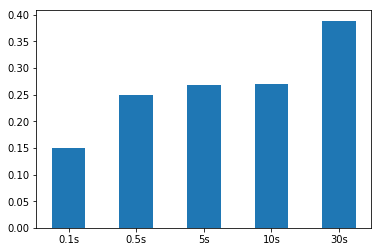

In [11]:
plt.figure()
plt.bar(np.arange(5), success_result, 0.5)
plt.xticks(np.arange(5), ('0.1s','0.5s','5s','10s','30s'))
plt.show()

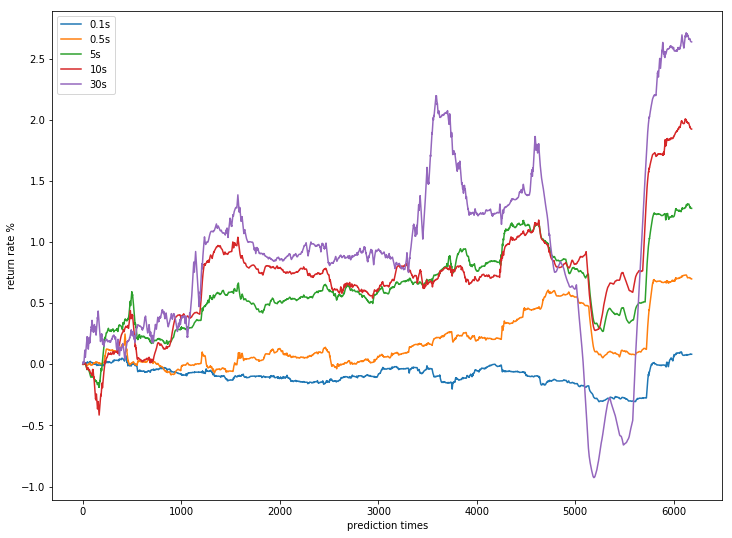

In [12]:
plt.figure(figsize=(12,9))
for i in return_result:
    plt.plot(i*100)
plt.legend(['0.1s','0.5s','5s','10s','30s'])
plt.xlabel('prediction times')
plt.ylabel('return rate %')
plt.show()

In [13]:
for i in return_result:
    print(i[-1])

0.0008187832985873111
0.006979511723059328
0.012752477106208637
0.01923717384037582
0.026369210878243843
